In [1]:
### Defining Environment variables pointing to user folders
from os import environ
import yaml

# load configuration file containing different training folders of different models
with open('train_conf.yaml', 'r') as file:
    train_conf = yaml.safe_load(file)
    
environ.setdefault("TARGET_TRAIN_DATASET","j100")
target_tset = environ['TARGET_TRAIN_DATASET']
models_collection = environ.get("MODELS_COLLECTION",dict())


for train_key in train_conf['training_folder'].keys():
    models_collection.setdefault(train_key,dict())
    
    models_collection[train_key].setdefault('HOME_DIR', "/workarea/local/shared/"+ environ['USERNAME'])
    models_collection[train_key].setdefault('TRAINING_DATA_FOLDER',train_conf['training_folder'][train_key])
    models_collection[train_key].setdefault('MODEL_STORAGE',models_collection[train_key]['HOME_DIR']+"/trained_models"+models_collection[train_key]['TRAINING_DATA_FOLDER'])

    feather_folder = models_collection[train_key]['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+models_collection[train_key]['TRAINING_DATA_FOLDER']
    models_collection[train_key].setdefault("TEST_DATA"      , feather_folder+"/covariance-test")
    models_collection[train_key].setdefault('INPUT_MODEL',models_collection[train_key]['MODEL_STORAGE']+"/models/covariance/saved_model.pb")

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

# Validation of the resolution model
##### This notebook was tested with the environment `LHCb Analysis Facility` as made available in the image `landerlini/lhcbaf:v0p8`.

This notebook is part of a pipeline, in particular it requires data preprocessed in the [Preprocessing-GANs notebook](./Preprocessing-GANs.ipynb) and the model trained in the [Covariance notebook](./Covariance.ipynb).

## Environment and libraries
As for other validation notebooks, we are using the GPU to process the data (selections and histogramming) which will make it unusable for evaluating the DNN models in tensorflow.
For a discussion on this issue, refer to the [acceptance-validation notebook](./Acceptance-validation.ipynb).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

The libraries for using the GPU for data analysis are:
 * `cupy`, as a replacement for numpy with operations running on the GPU
 * `cudf`, as a replacement for pandas with a DataFrame stored on GPU
 * `dask` to implement lazy operations and streaming data from disk to the GPU memory, on demand.

In [3]:
import dask.dataframe as ddf
import cudf
import cupy as cp

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

We are using a dataset statistically equivalent to the une used for training, but never loaded in the training notebook.
We will use our custom [`FeatherReader`](./feather_io.py) helper function, converting data to a `dask` dataframe while they are read from disk.

In [4]:
from feather_io import FeatherReader
data_reader = FeatherReader(environ.get("TEST_DATA", "covariance-test"))
test_dataset = data_reader.as_dask_dataframe()

## Loading model, preprocessing and postprocessing steps
Preprocessing steps are obtained from the same directory as the model with the standard naming convention:
 * `tX.pkl` for the preprocessing step
 * `tY.pkl` for the postprocessing step
 
Please note that `tY` encodes the transformation from physics variables to normally-distributed preprocessed features.
In this notebook we are interested in the inverse transformation, mapping the output of the generator (normally distributed features) to the physics quantities.

In [5]:
import preprocessing_utils
from preprocessing_utils import DecorrTransformer

target_input_model = os.path.dirname(models_collection[target_tset]["INPUT_MODEL"])
for train_key in models_collection.keys():
    models_collection[train_key]['model_dir'] = os.path.dirname(models_collection[train_key]['INPUT_MODEL'])
    models_collection[train_key]['covariance_model'] = tf.keras.models.load_model(models_collection[train_key]['model_dir'])
tX = preprocessing_utils.load_from_pickle("COVARIANCE_PREPROCESSING_X", os.path.join(target_input_model, "tX.pkl"))
tY = preprocessing_utils.load_from_pickle("COVARIANCE_PREPROCESSING_Y", os.path.join(target_input_model, "tY.pkl"))

## Processing pipeline
We define a lazy pipeline using dask to:
 * load the data from disk (implemented by `FeatherReader`)
 * transform both the preprocessed conditions and target features into the original physics quantities
 * generate the random noise
 * evaluate the generator on the preprocessed conditions and generated noise
 * apply the inverse preprocessing step to the generated features to retrieve physics quantities (postprocessing)
 * upload the resulting dataset to device memory for further processing

In [6]:
from validation_utils import invert_column_transformer

def process_batch(batch, preprocessorX, preprocessorY, features, labels):
    pX = batch[features].values.astype(np.float32)
    pY = batch[labels].values.astype(np.float32)
    
    batch[features] = invert_column_transformer(preprocessorX, pX)
    batch[labels] = preprocessorY.inverse_transform(pY)

    batch_size = pX.shape[0]
    rX = np.random.normal(0., 1., [batch_size, 128]).astype(np.float32)
    for train_key in models_collection.keys():
        covariance_model = models_collection[train_key]['covariance_model']
        pY_hat = covariance_model.predict((pX, rX), batch_size=len(pX), verbose=False)
        batch[[f'predicted_{y}_{train_key}' for y in labels]] = preprocessorY.inverse_transform(pY_hat)
    
    return batch

from functools import partial
my_process_batch = partial(process_batch, 
                        features=data_reader.features, 
                        labels=data_reader.labels, 
                        preprocessorX=tX,
                        preprocessorY=tY,
                       )

## You may need to install dask-cudf
#mamba install -n base dask-cudf -y -c rapidsai -c conda-forge -c nvidia/label/cuda-11.7.0

cdf = (
    ddf
    .map_partitions(my_process_batch, test_dataset)
    .map_partitions(cudf.DataFrame.from_pandas)
)

INFO:tensorflow:Assets written to: ram://29e3633b-2c4f-4a37-8b96-702e0ebcb790/assets
INFO:tensorflow:Assets written to: ram://1fa21c20-9f3d-439b-b28a-a699f3577612/assets


#### Adding variables to the dataframe
We append to the pipeline the computation of variables that we wish using for binning the dataset but do not enter directly in the training dataset.

The list of the variables computed include:
 * the components of the momentum (from momentum and the slopes)
 * the pseudorapidity $\eta$
 * the azimuthal angle $\phi$
 * the relative error on the momentum $\frac{\Delta p}{p}$

In [7]:
def compute_momentum(df):
    df['mc_p'] = 10**df['mc_log10_p']
    df['p_GeV'] = df.mc_p/1e3
    df['mc_tx'] = df['true_tx_ClosestToBeam']
    df['mc_ty'] = df['true_ty_ClosestToBeam']
    df['mc_pz'] = (df.mc_p**2 / (1 + df.mc_tx**2 + df.mc_ty**2))**0.5
    df['mc_px'] = df.mc_pz * df.mc_tx
    df['mc_py'] = df.mc_pz * df.mc_ty
    df['mc_pt'] = (df.mc_px**2 + df.mc_py**2)**0.5
    return df

def compute_eta(df):    
    mc_theta = cp.arcsin(df.mc_pt/df.mc_p)
    df['mc_eta'] = -cp.log(cp.tan(mc_theta/2))
    return df

def compute_phi(df):
    df['mc_phi'] = cp.arctan2(df.mc_py, df.mc_px)
    return df


ccdf = (
    cdf
    .map_partitions(compute_momentum)
    .map_partitions(compute_eta)
    .map_partitions(compute_phi)
)

## Distribution of the output features in kinematic bins
The following histogram show a comparison of the distribution of the generated and reference output features in kinematic bins.
The comparison is split per particle type (electron, muon and hadron) and track class (long, upstream and downstream), resulting into nine comparisons for each output feature.

In [8]:
binning_schemes = dict(
    dx=cp.linspace(-10, 10, 41),
    dy=cp.linspace(-10, 10, 41),
    dz=cp.linspace(-200, 200, 41),
    dtx=cp.linspace(-0.05, 0.05, 41),
    dty=cp.linspace(-0.05, 0.05, 41),
    dp_rel=cp.linspace(-0.5, 0.5, 41),
    chi2PerDoF=cp.linspace(0, 4, 41),
    nDoF_f=cp.linspace(10, 40, 31),
    ghostProb=cp.linspace(0, 0.4, 41),
)

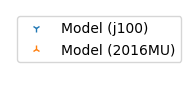

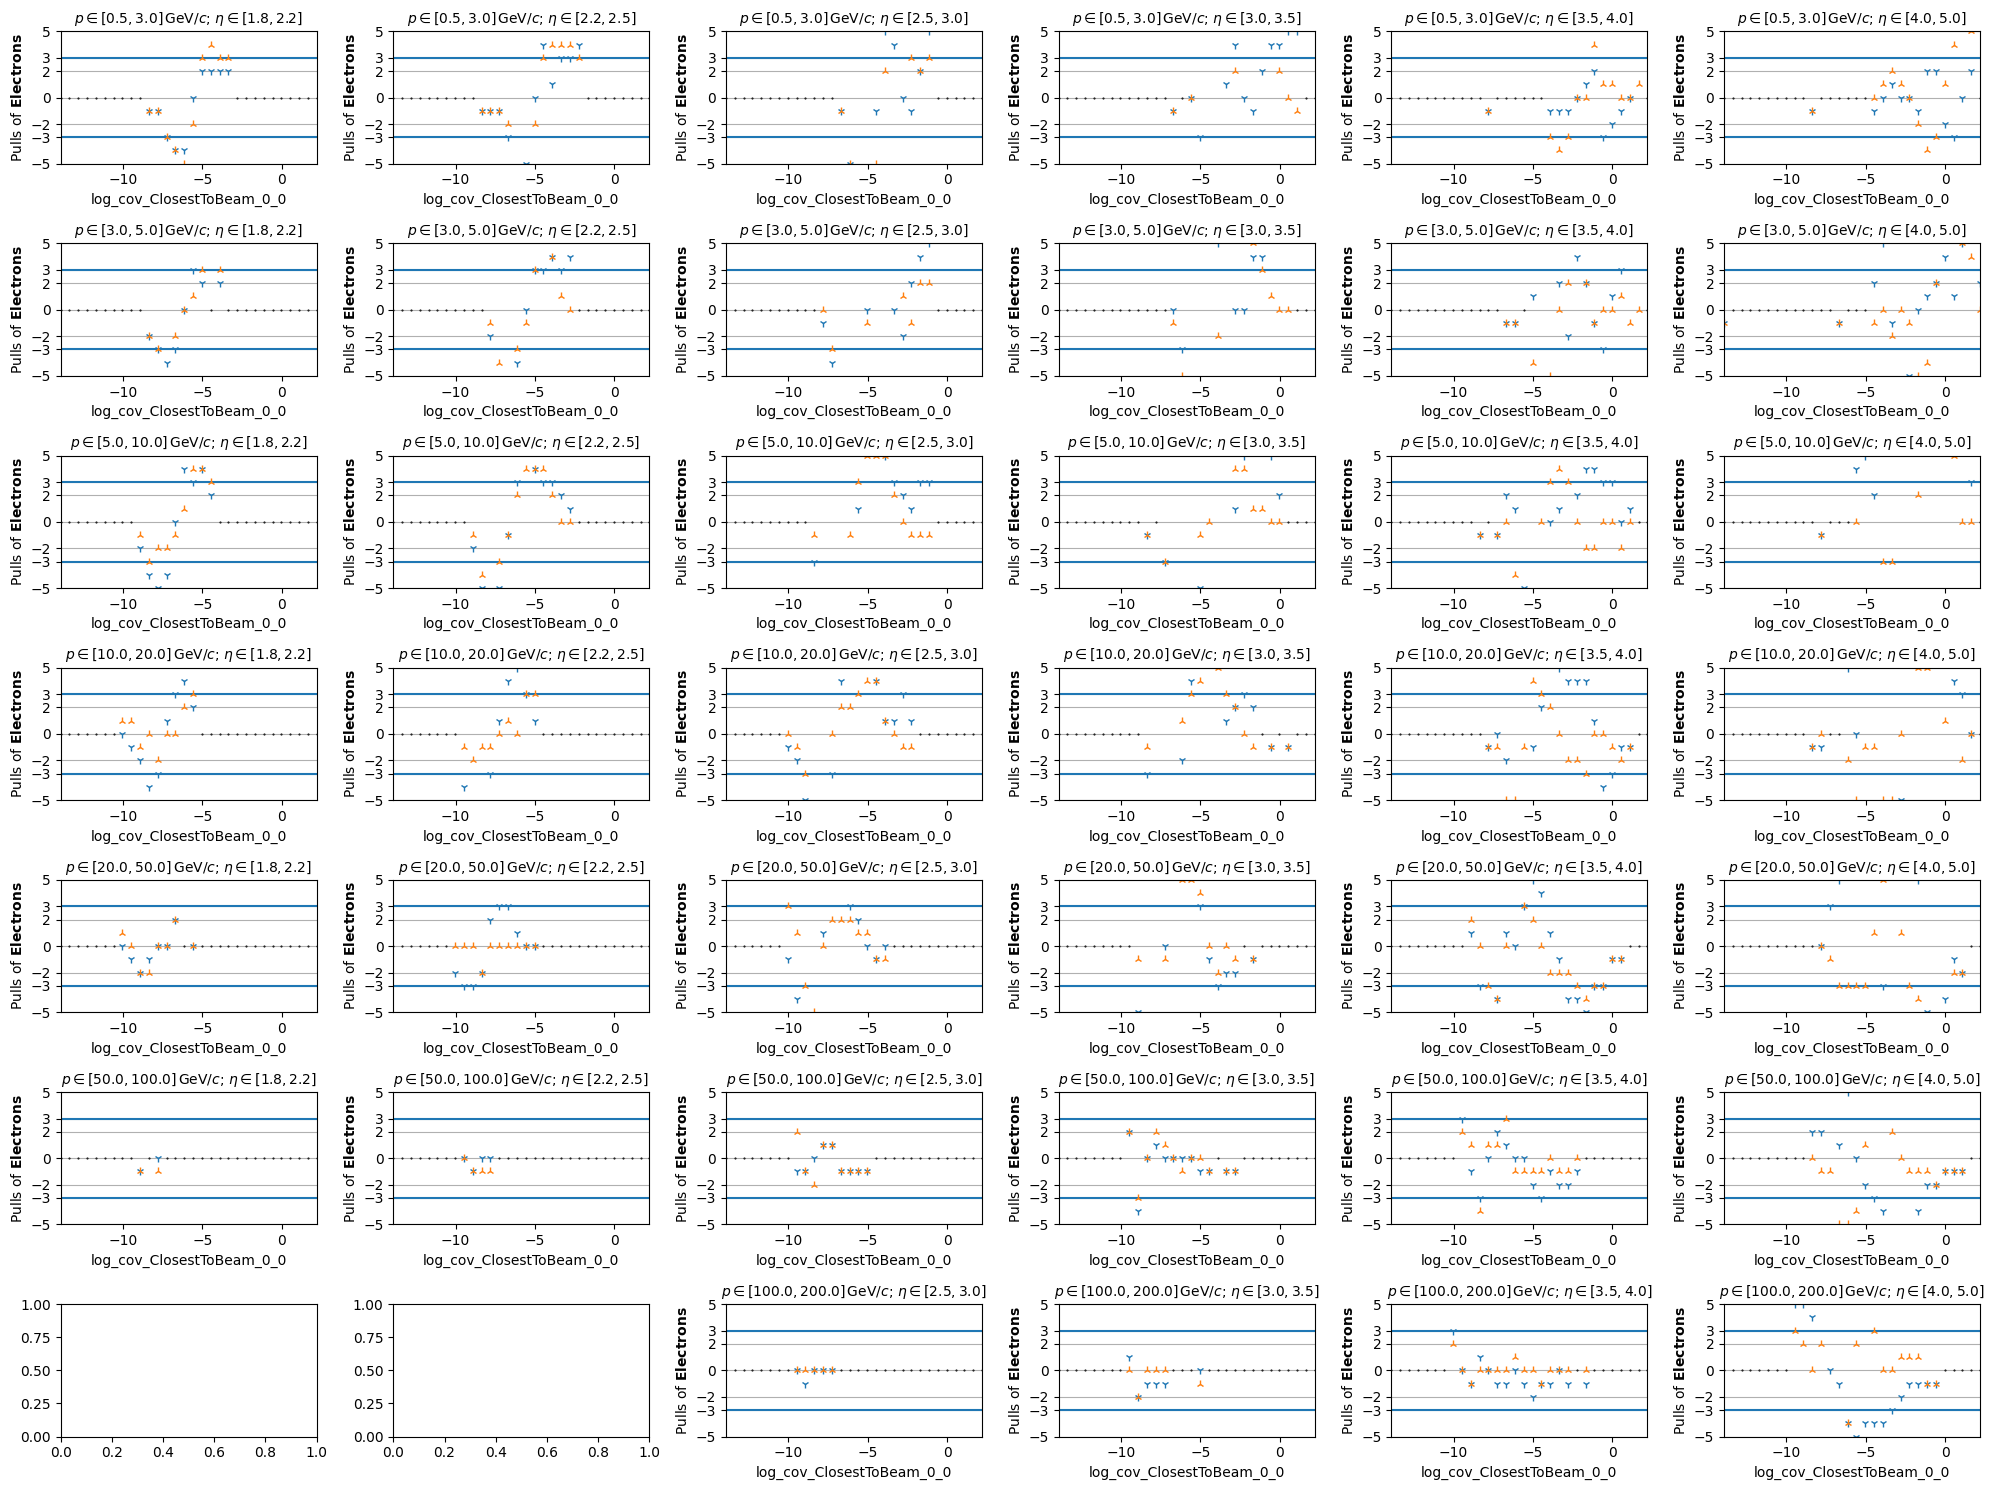

In [22]:
## import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.stats import ks_2samp

track_types = ['long', 'upstream', 'downstream']
labels = data_reader.labels.copy()

parts = ['e', 'mu', 'h']
p_boundaries = [0.5, 3., 5., 10., 20., 50., 100., 200.]
eta_boundaries = [1.8, 2.2, 2.5, 3., 3.5, 4., 5.]

markers = {
    0 : "1",
    1 : "2",
    2 : "3",
    3 : "4",
}

show_plots=True

ks_tests = dict(zip(models_collection.keys(),[[] for k in models_collection.keys()]))

display(HTML("<H1>Legend</H1>"))
plt.figure(figsize=(2,1))
for i,train_key in enumerate(models_collection.keys()):
    plt.errorbar([i],[1],label=f"Model ({train_key})",fmt=markers[i%4])
    plt.xlim(0.1,0.2)
    plt.legend(loc="upper left")
    plt.gca().axis('off')
plt.tight_layout()
plt.show()

for track_type in track_types:
    display(HTML(f"<H2>{track_type.capitalize()} tracks</H2>"))
    for part in parts:
        part_name = dict(h="hadron", e="electron", mu="muon")[part]
        display(HTML(f"<H3>Particle type: <U>{part_name}</U></H3>"))

        for label in labels:
            display(HTML(f"<H4>Variable: <FONT style='font-family: monospace; color: red;'>{label}</FONT> for <U>{part_name}s</U> with <B>{track_type}</B> tracks</H4>"))
            plot_cols = ["p_GeV", "mc_eta", label]+[f"predicted_{label}_{train_key}" for train_key in models_collection.keys()]
            plot_df = ccdf.query(f"{track_type}==1 and mc_is_{part} == 1")[plot_cols].compute()
            bins = binning_schemes.get(label, cp.linspace(plot_df[label].min(), plot_df[label].max(), 31))
            
            iPlot = 0
            if show_plots:
                plt.figure(figsize=(20,15))
                
            for p_min, p_max in zip(p_boundaries[:-1], p_boundaries[1:]):
                for eta_min, eta_max in zip(eta_boundaries[:-1], eta_boundaries[1:]):
                    iPlot += 1
                    if show_plots:
                        plt.subplot(len(p_boundaries)-1, len(eta_boundaries)-1, iPlot)
                        
                    bin_df = plot_df.query(f"p_GeV > {p_min} and p_GeV < {p_max} and mc_eta > {eta_min} and mc_eta < {eta_max}")
                    if len(bin_df)==0:
                        continue 
                        
                    h_true, _ = cp.histogram(bin_df[label].values, bins=bins)
                    where = h_true!=0
                    h_pred = dict()
                    pulls,sigma  = dict(),dict() # number of sigmas from true value
                    for train_key in models_collection.keys():
                        h_pred[train_key], _ = cp.histogram(bin_df[f"predicted_{label}_{train_key}"].values, bins=bins)
                        sigma[train_key] = cp.sqrt(h_pred[train_key]+h_true)
                        
                        pulls[train_key] = cp.zeros_like(h_true)
                        pulls[train_key][where] = cp.divide((h_pred[train_key] - h_true)[where],sigma[train_key][where])
                        
                        ks_tests[train_key].append(
                        [track_type, part, label, p_min, p_max, eta_min, eta_max, len(bin_df),
                         *ks_2samp(bin_df[label].values.get(), bin_df[f"predicted_{label}_{train_key}"].values.get())])
                                        
                    xAxis = 0.5*(bins[:-1] + bins[1:])
                    
                    if show_plots:
                        #mark points where the True histogram has empty bins
                        plt.errorbar(xAxis[~where].get(), np.zeros_like(xAxis[~where].get()),
                                     yerr=None, xerr=None, fmt='.',color="black",markersize=1)
                        for i,train_key in enumerate(models_collection.keys()):
                            plt.errorbar(xAxis[where].get(), pulls[train_key][where].get(), yerr=None,
                                         xerr=None, label=f"Model ({train_key})", fmt=markers[i%len(markers)])

                        plt.xlabel(label)
                        plt.ylabel(f"Pulls of $\mathbf{{{part_name.capitalize()}s}}$")
                        plt.title(f"$p \in [{p_min:.1f}, {p_max:.1f}]\, \mathrm{{GeV}}/c$; $\eta \in [{eta_min:.1f}, {eta_max:.1f}]$",
                                 fontsize='medium') 
                        #plt.yscale('log')
                        plt.ylim(-5,5)
                        plt.xlim(xAxis[0],xAxis[-1])
                        plt.yticks([-5,-3,-2,0,2,3,5])
                        plt.grid(axis='y')
                        plt.axhline(y=3)
                        plt.axhline(y=-3)

            if show_plots:
                plt.tight_layout()
                plt.show()
            #break
        #break
    #break
    
for train_key in models_collection.keys():
    ks_tests[train_key] = pd.DataFrame(
        ks_tests[train_key], 
        columns=[
            'track_type', 'part_type', 'variable', 'p_min', 'p_max', 'eta_min', 'eta_max', 
            'n_samples', 'ks_stat', 'p_value'])

## Kolmogorov-Smirnov distance as a quality metric
To assess the overall quality of the dataset we are using the KS distance as computed from the histograms discussed above.
For each kinematic bin with a sufficient number of samples (100 or more) and for each output feature, we compute the KS distance.
The KS distances are used to fill a histogram that provides a visual summary of the fitting of the model to the reference sample across the kinematic region covered by the training sample.

In general, we aim at the lowest possible values of the KS distance. 
In practice, values below 0.1 are conventionally considered as very good and values below 0.3 are considered acceptable.
These thresholds may change increasing the statistics of the test set.

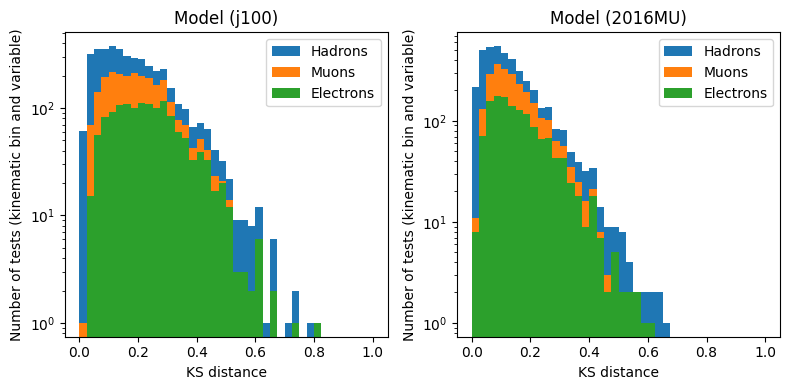

In [14]:
n_models = len(models_collection.keys())
fig,ax = plt.subplots(1,n_models,figsize=(4*n_models,4))
reliable_ks_tests = dict()
for i,train_key in enumerate(models_collection.keys()):
    reliable_ks_tests[train_key] = ks_tests[train_key].query("n_samples > 100")
    ax[i].hist(reliable_ks_tests[train_key].ks_stat, bins=np.linspace(0,1,41), label="Hadrons")
    ax[i].hist(reliable_ks_tests[train_key].query("part_type!='h'").ks_stat, bins=np.linspace(0,1,41), label="Muons")
    ax[i].hist(reliable_ks_tests[train_key].query("part_type=='e'").ks_stat, bins=np.linspace(0,1,41), label="Electrons")
    ax[i].set_xlabel("KS distance")
    ax[i].set_ylabel("Number of tests (kinematic bin and variable)")
    ax[i].set_title(f"Model ({train_key})")
    ax[i].legend()
    ax[i].set_yscale('log')
plt.tight_layout()
plt.show()

### KS distance across the kinematic space
In the plot below, we report the value of the KS distance as a function the kinematic bin.
The purpose of this visualization is to identify regions where the model performs better and regions where it is weaker.
In general, it is observed, as expected, that the model performs better in regions where the training dataset is more populated.

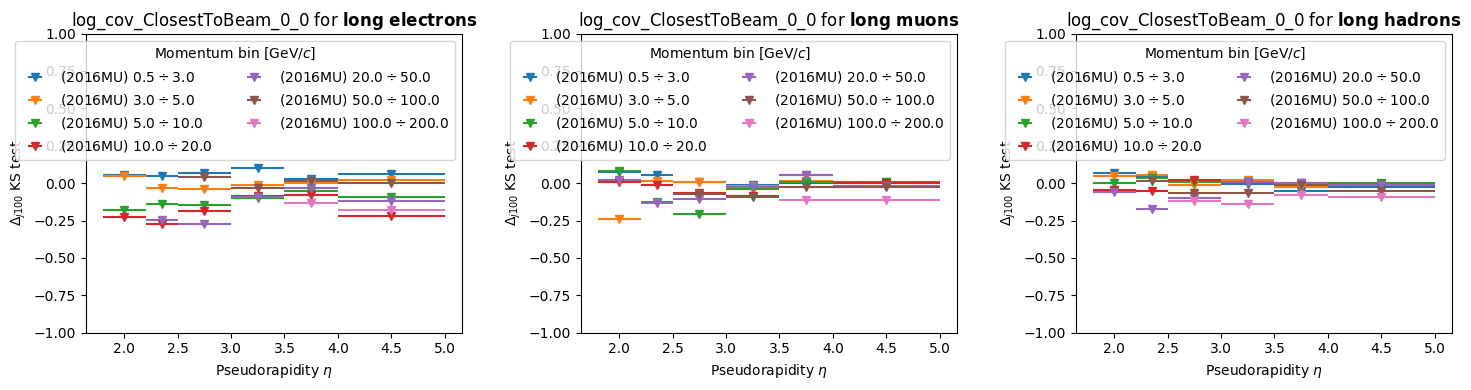

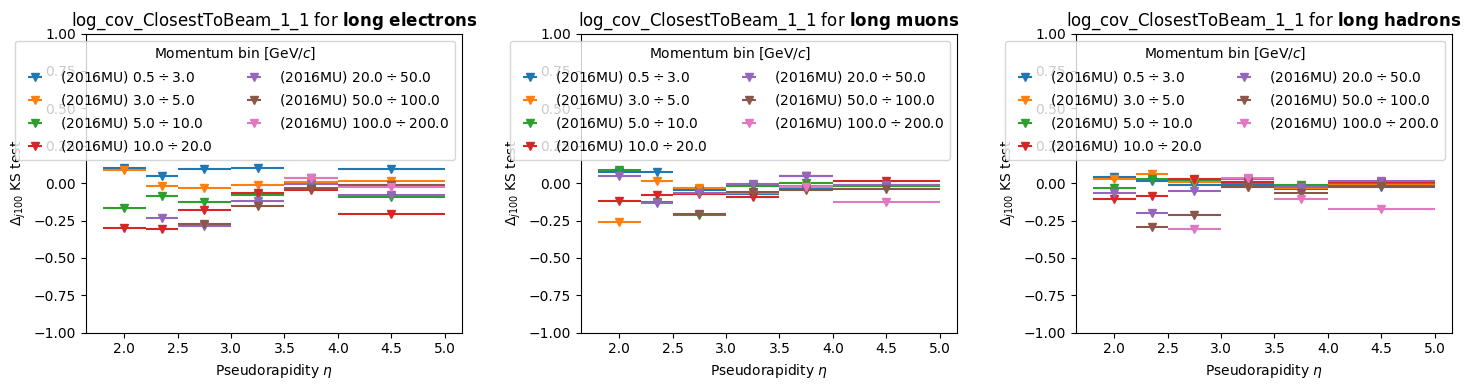

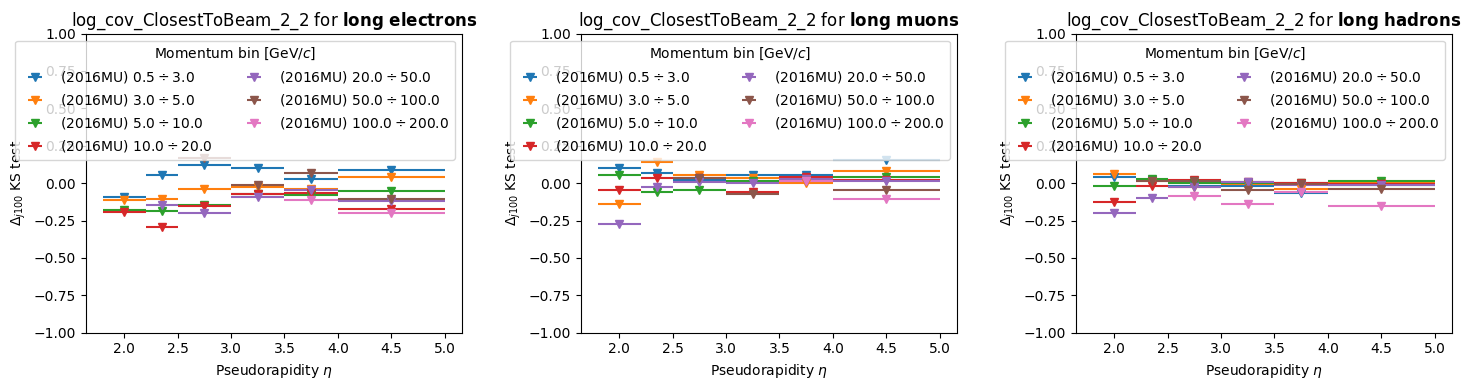

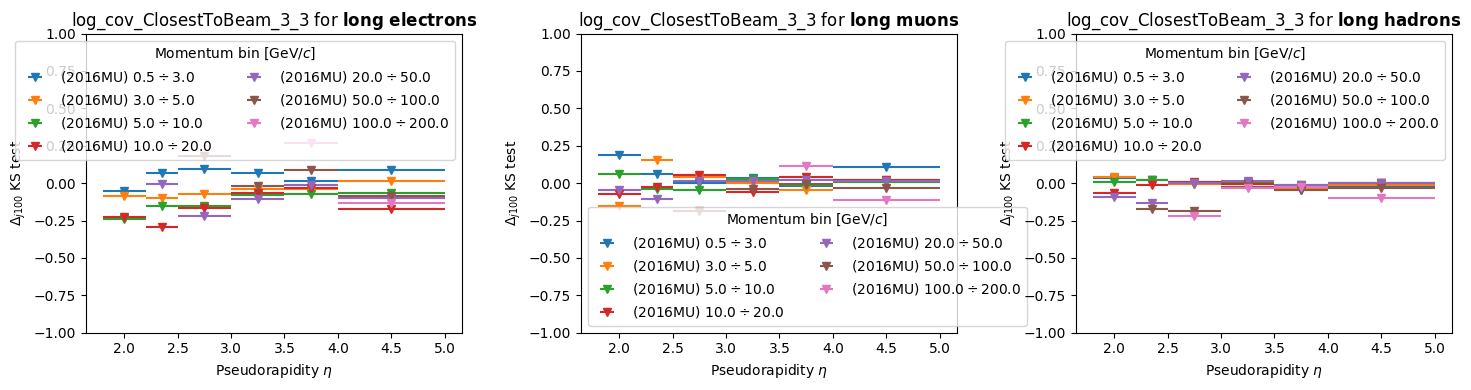

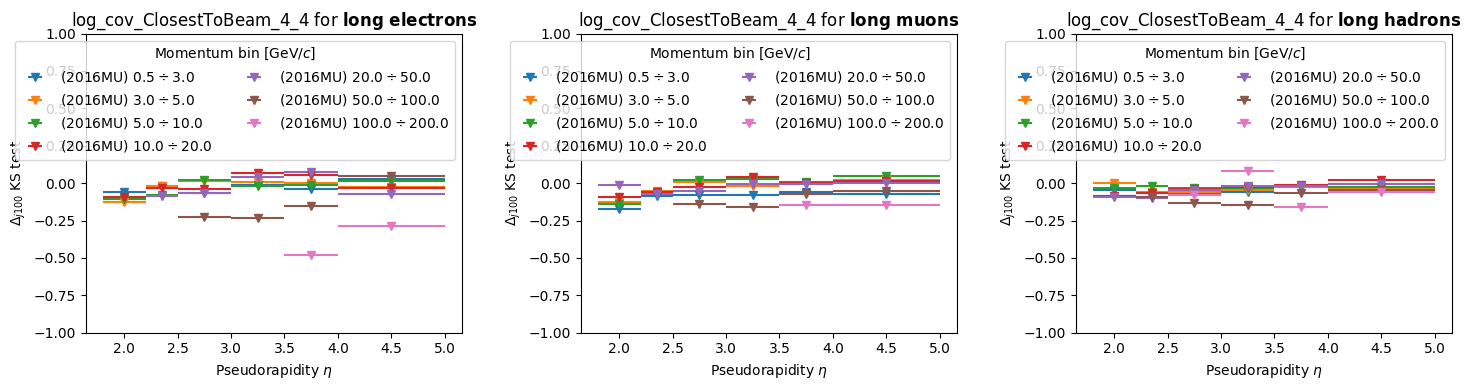

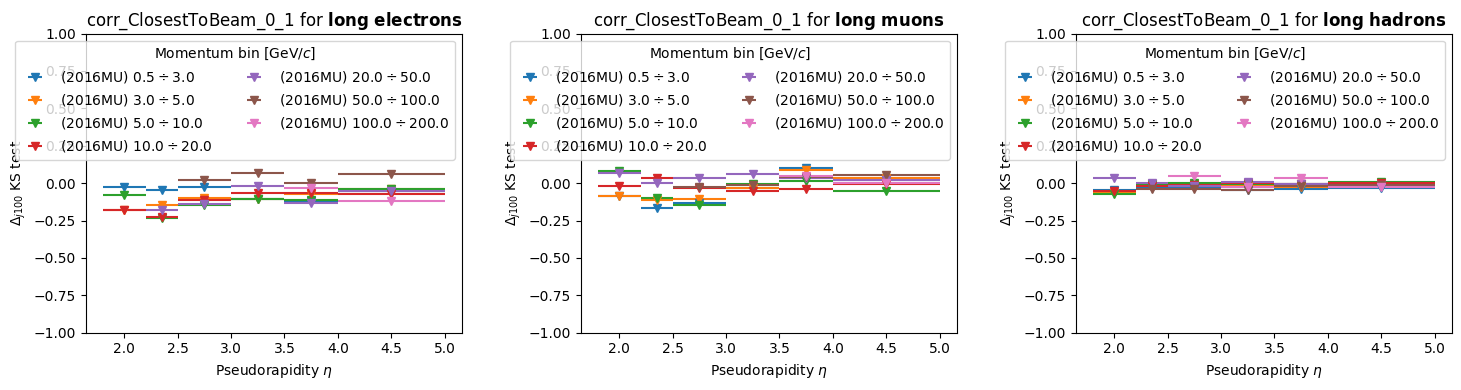

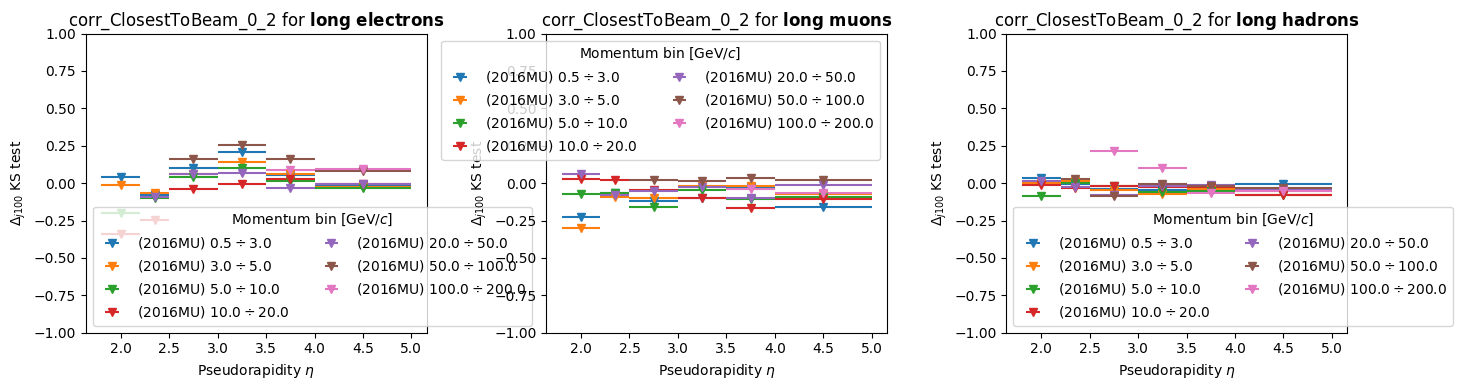

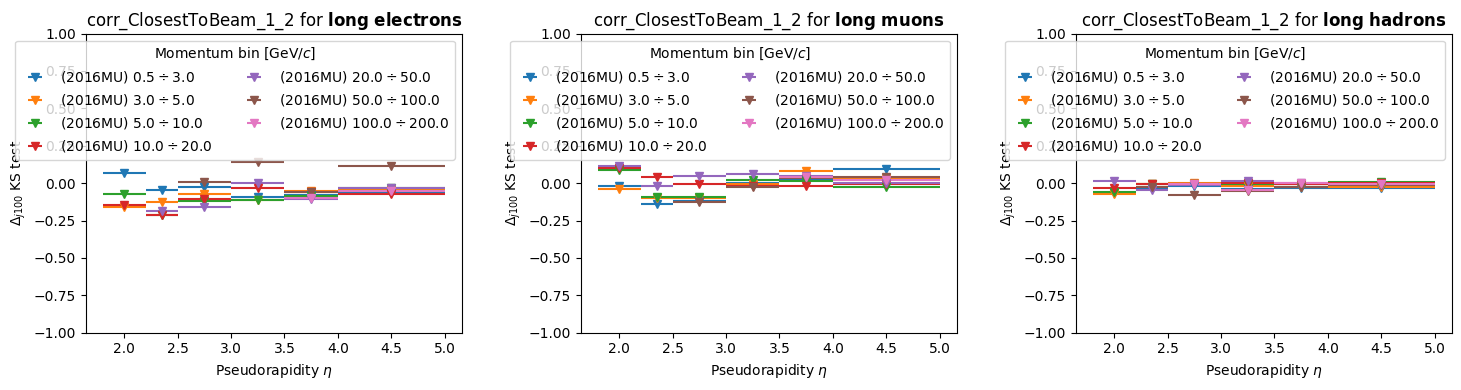

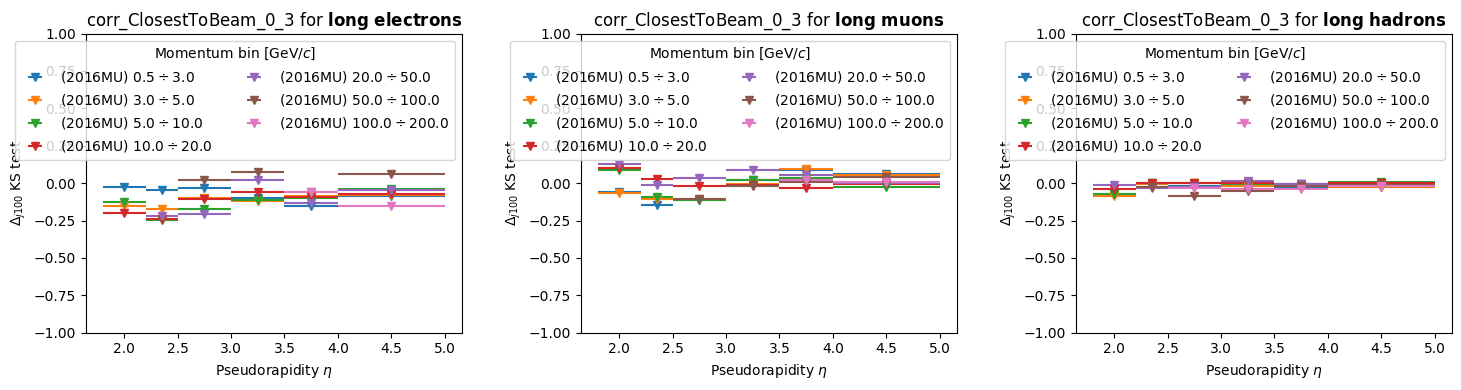

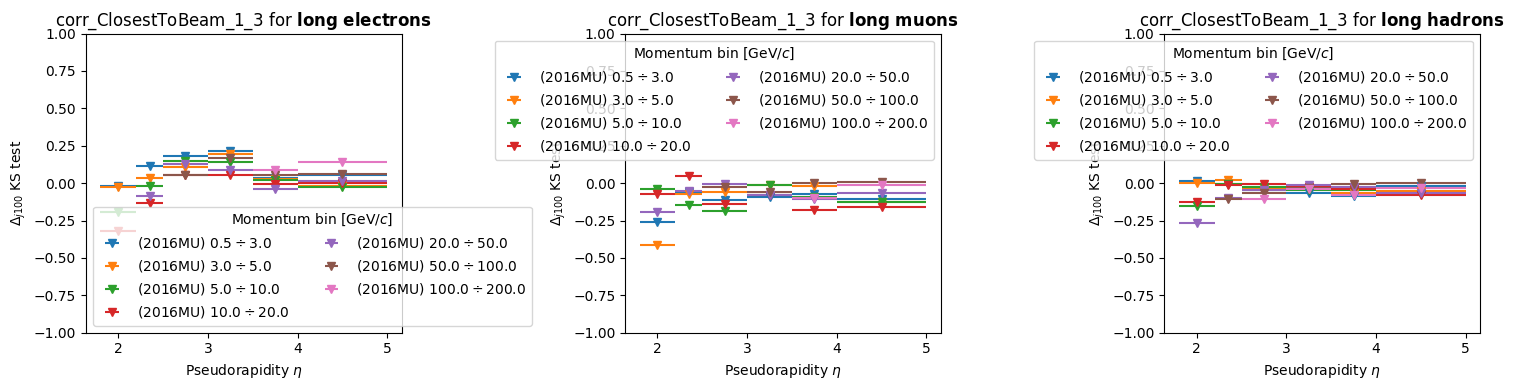

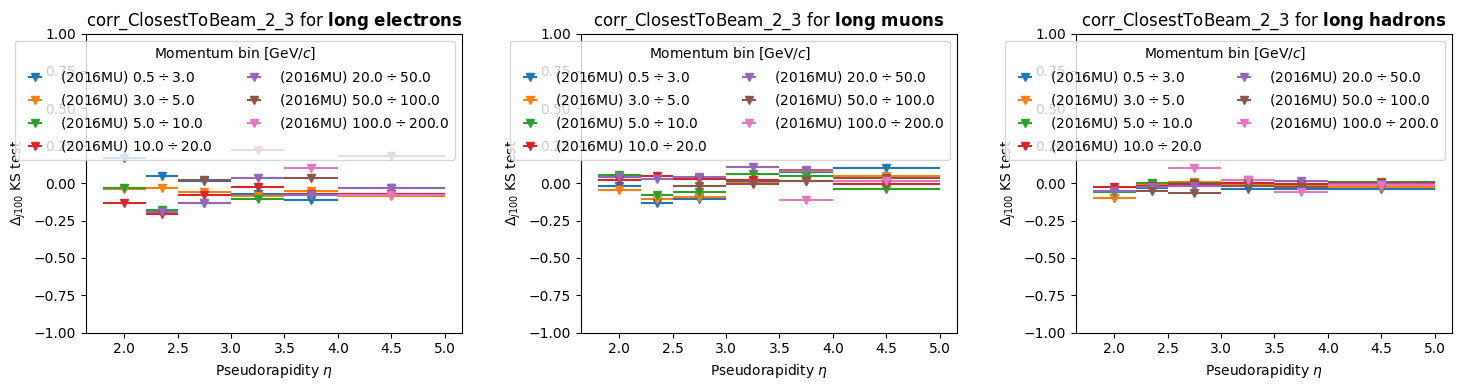

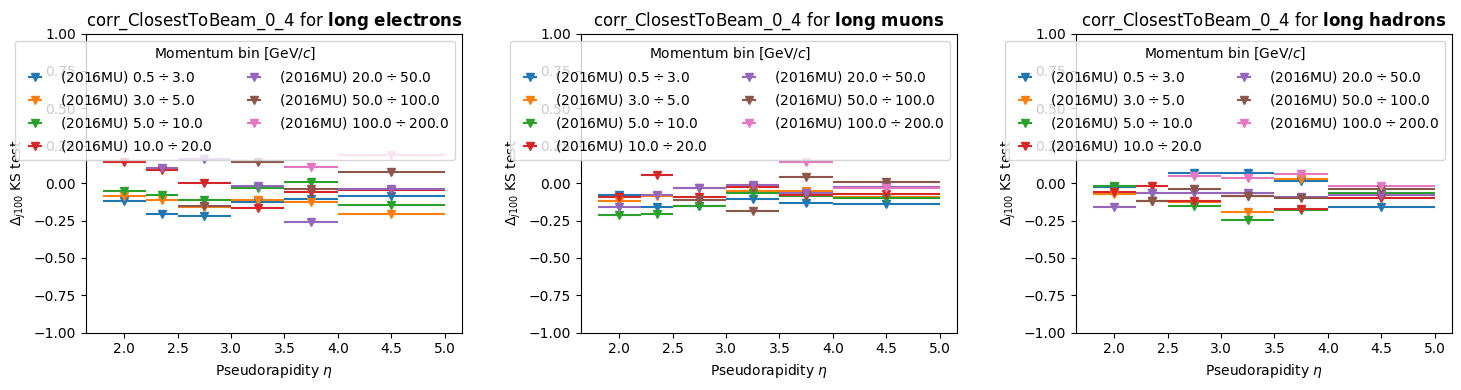

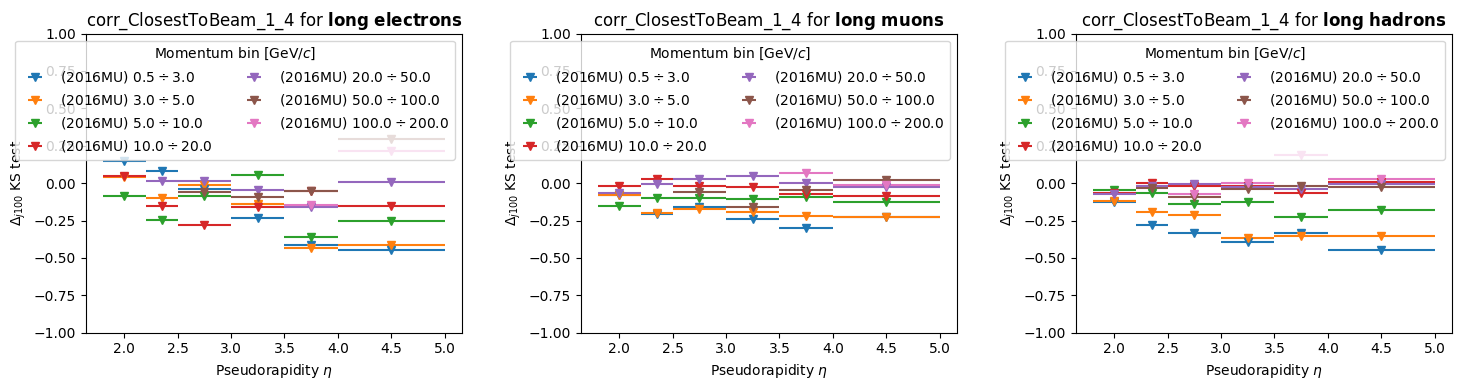

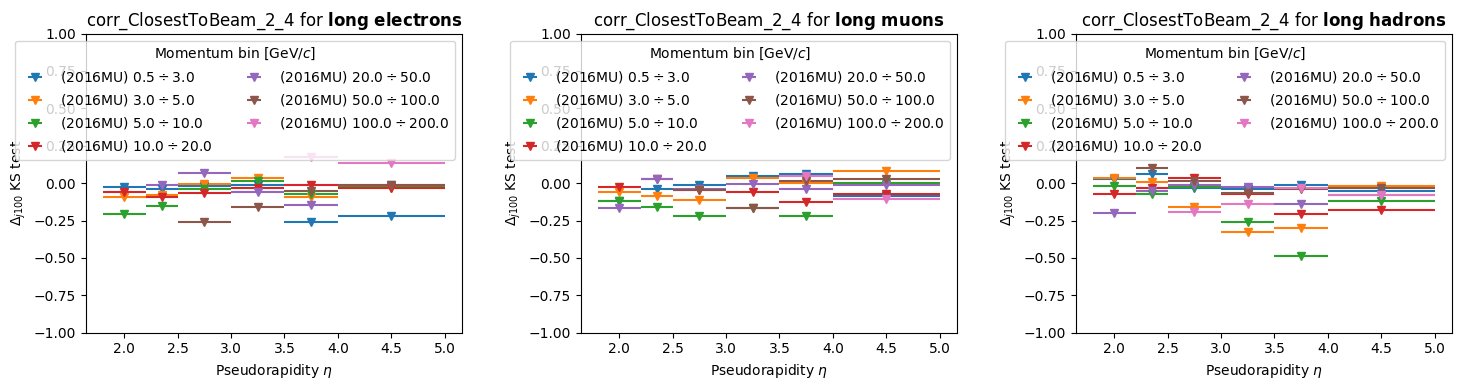

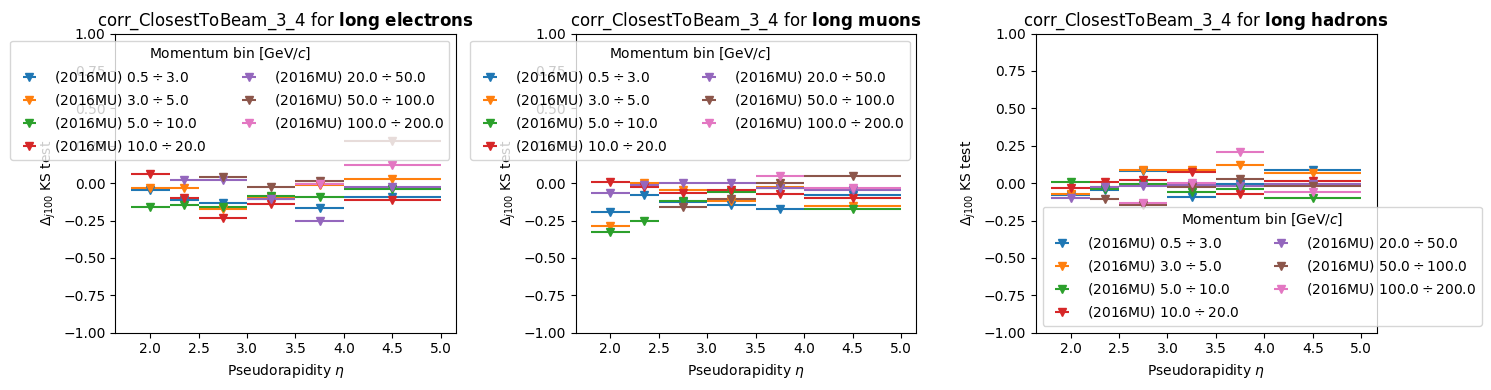

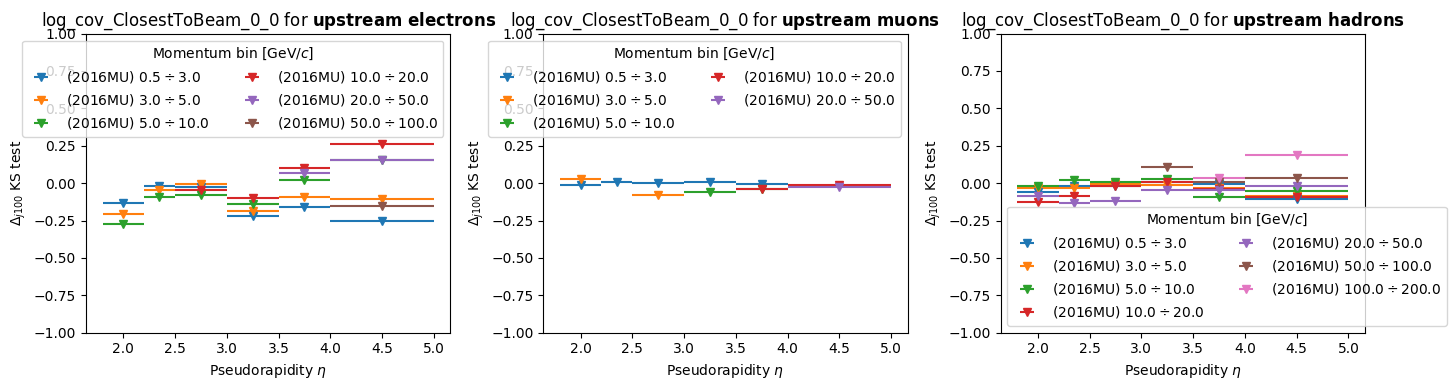

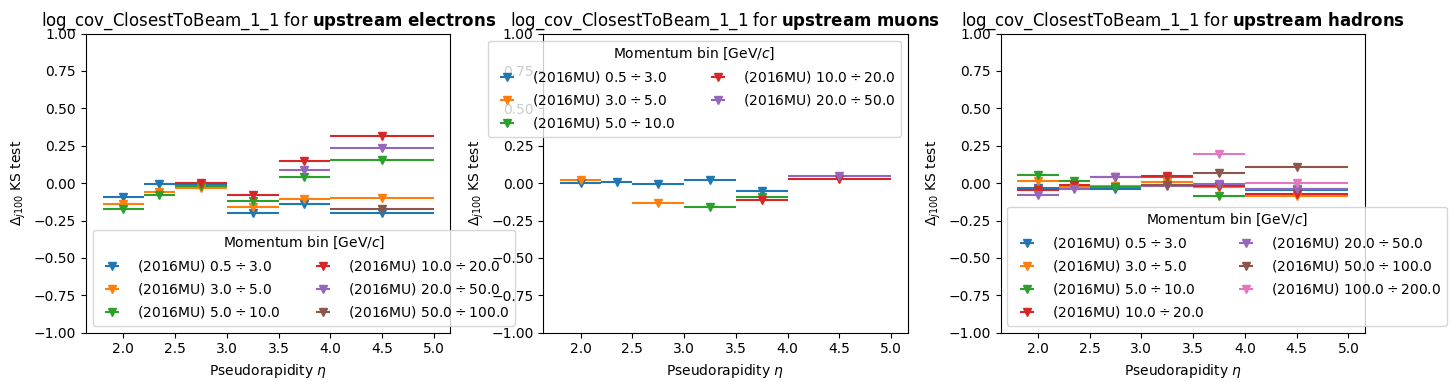

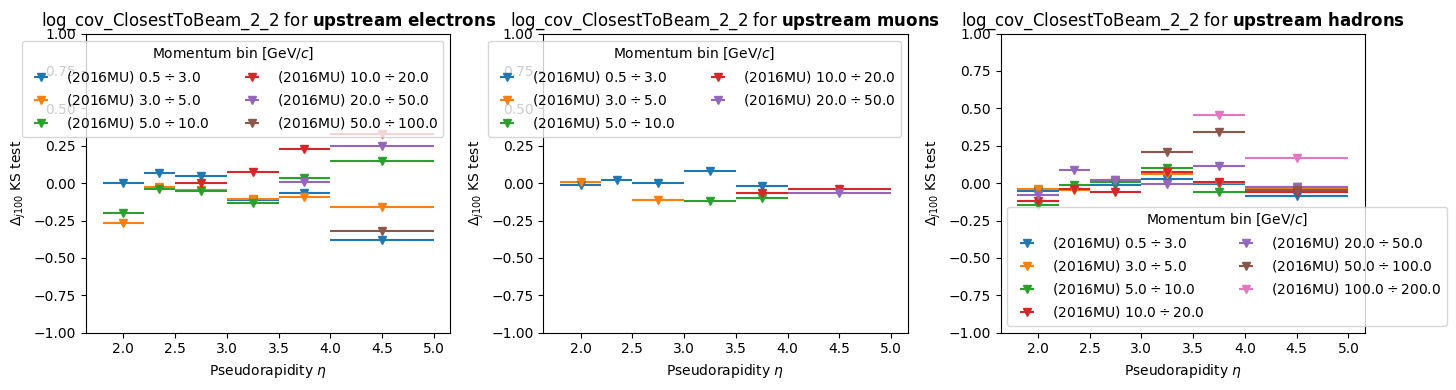

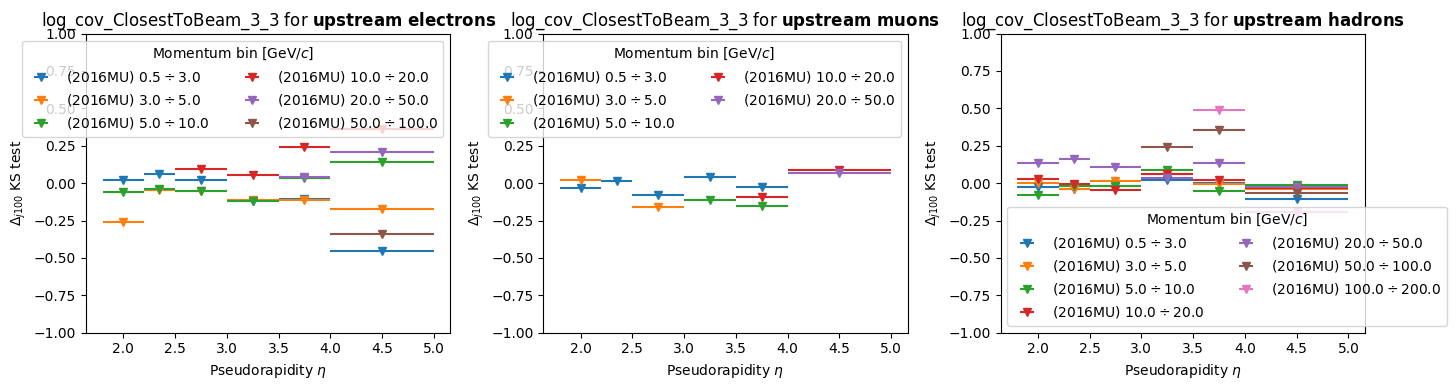

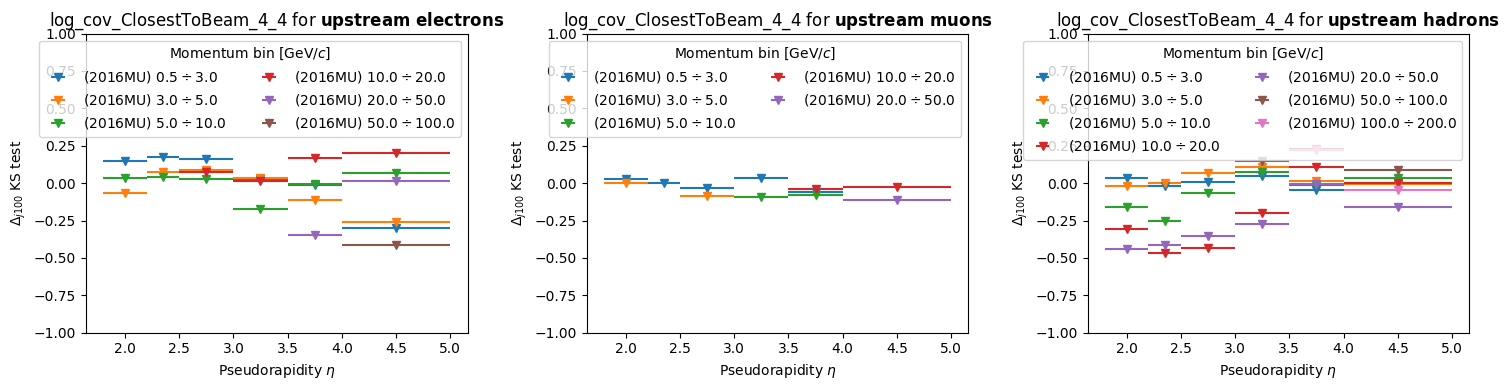

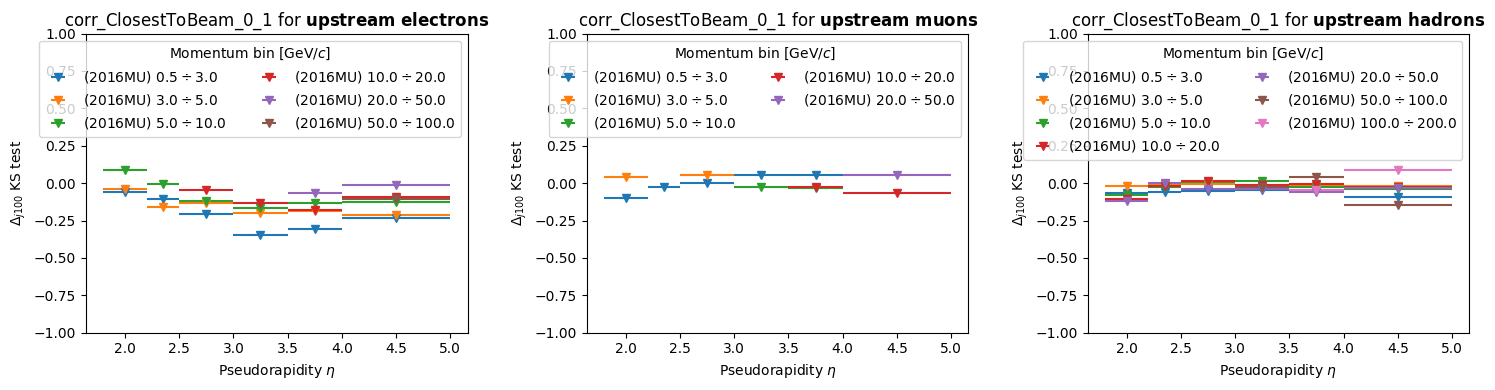

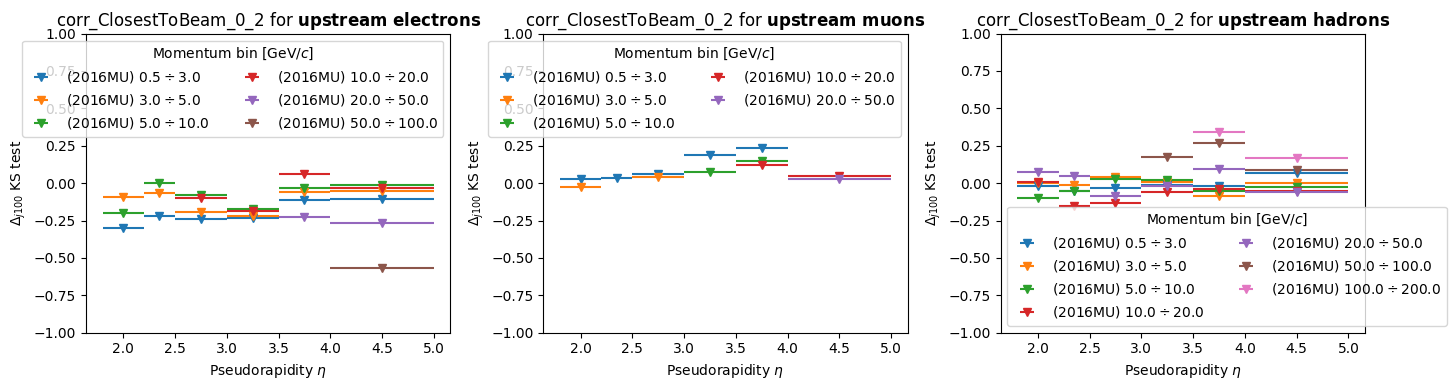

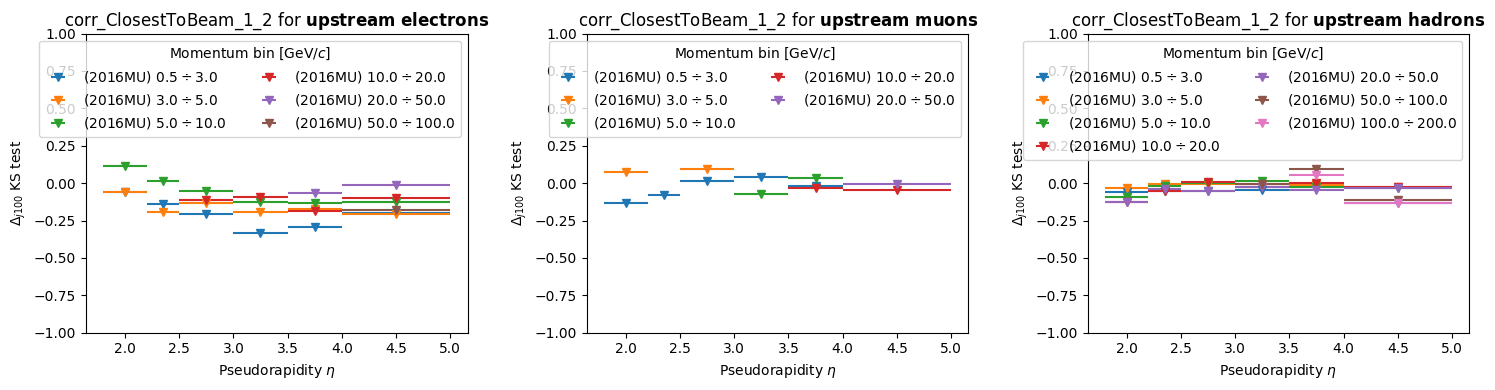

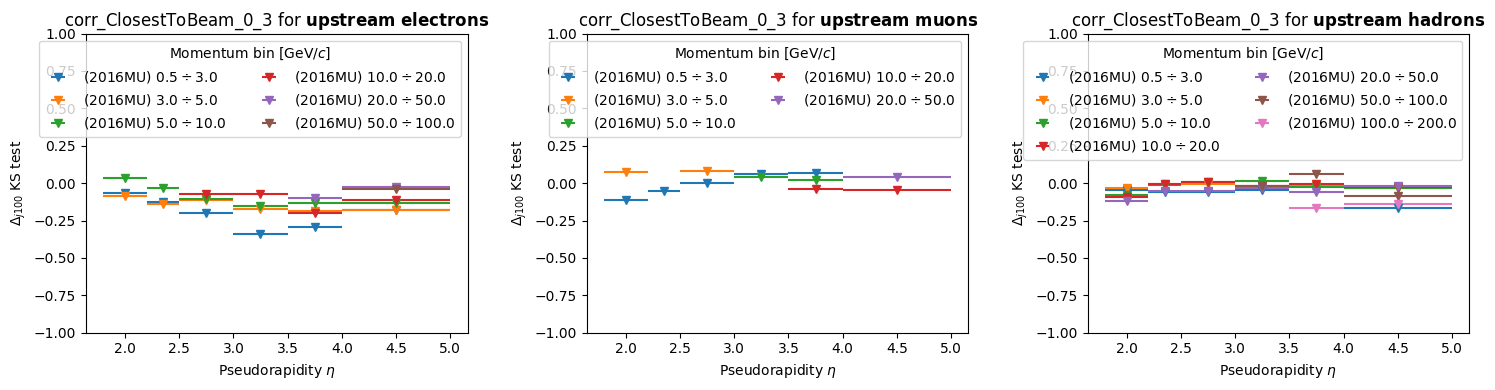

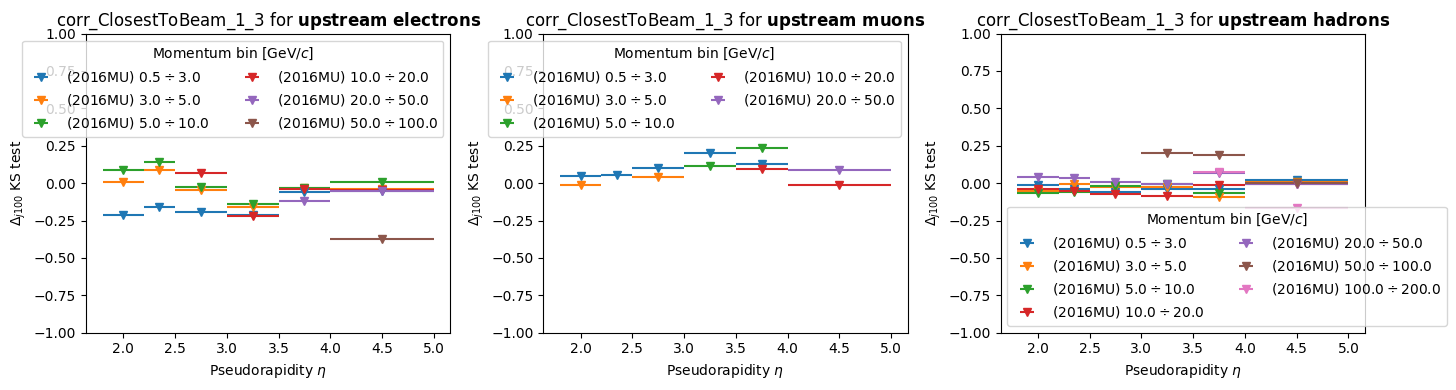

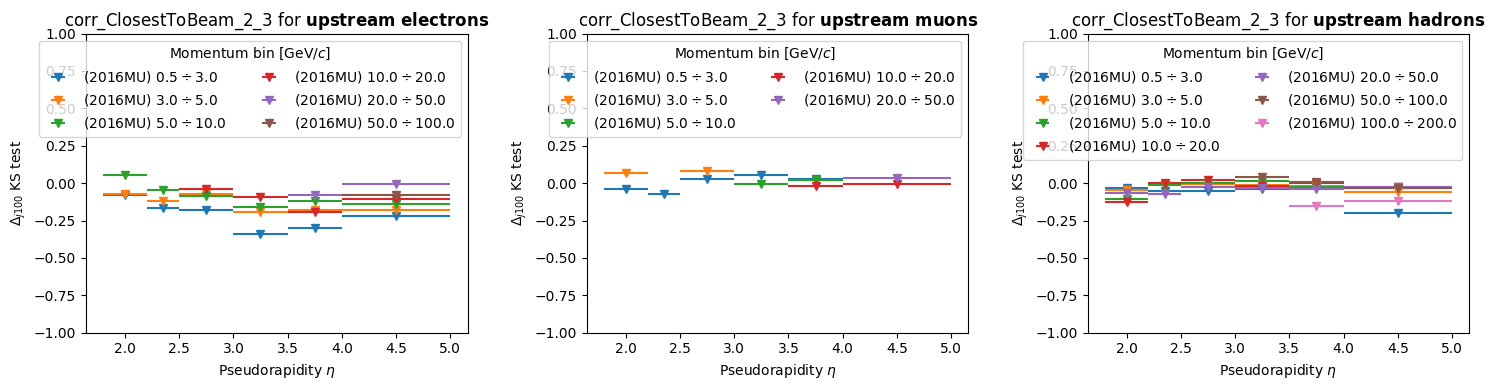

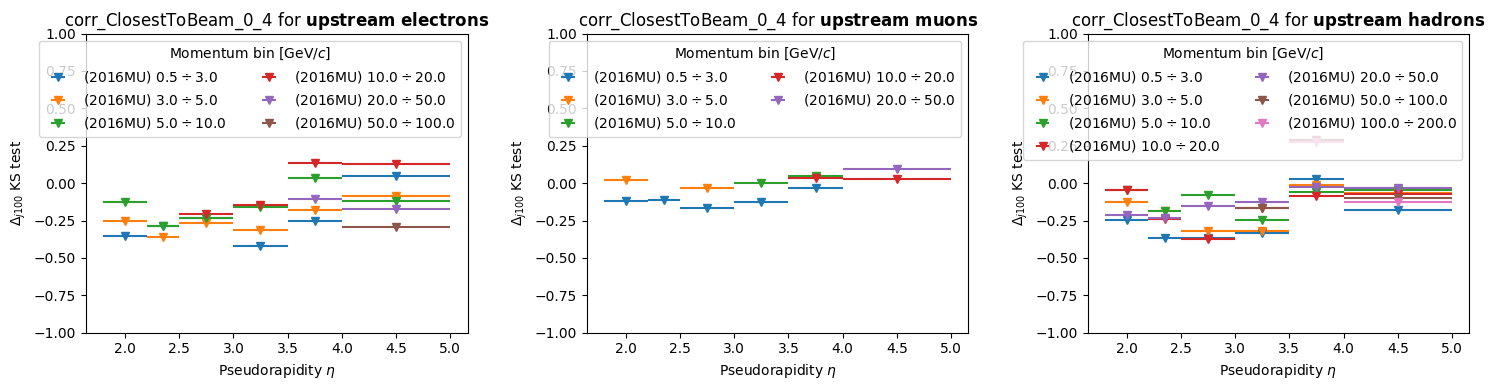

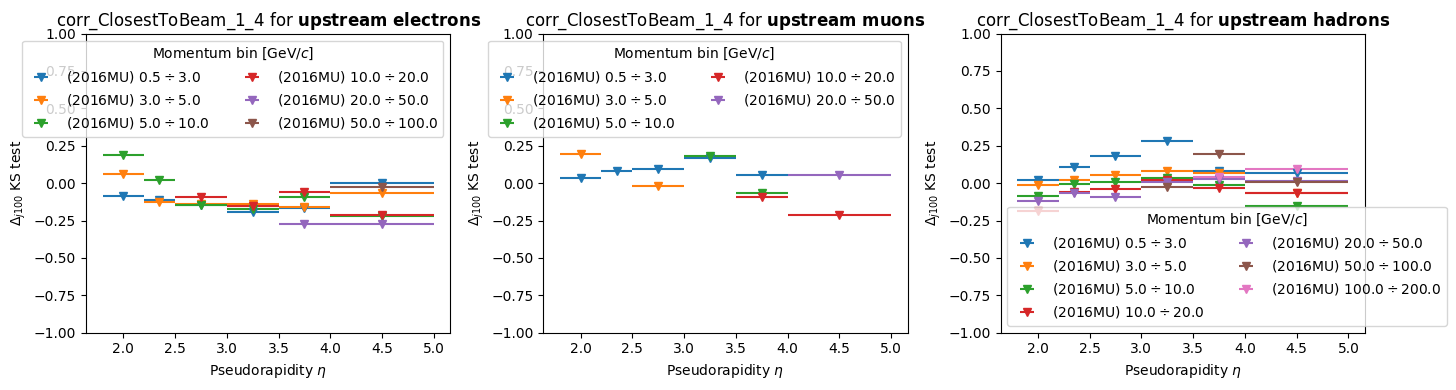

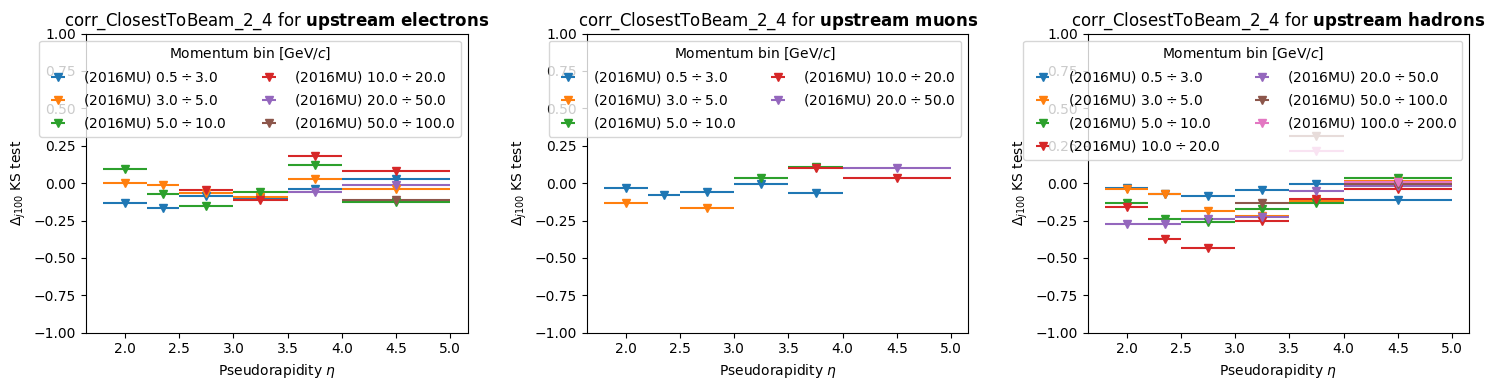

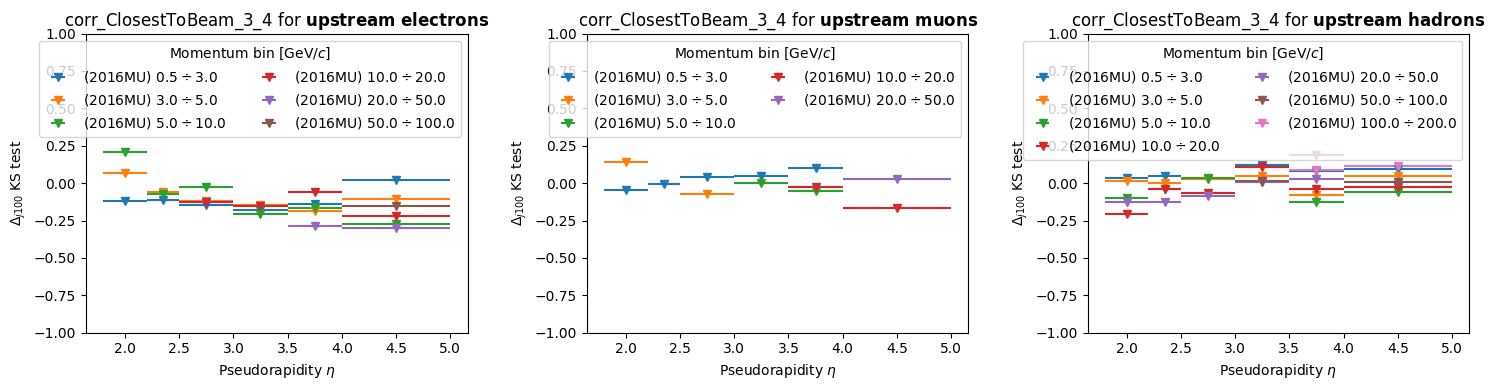

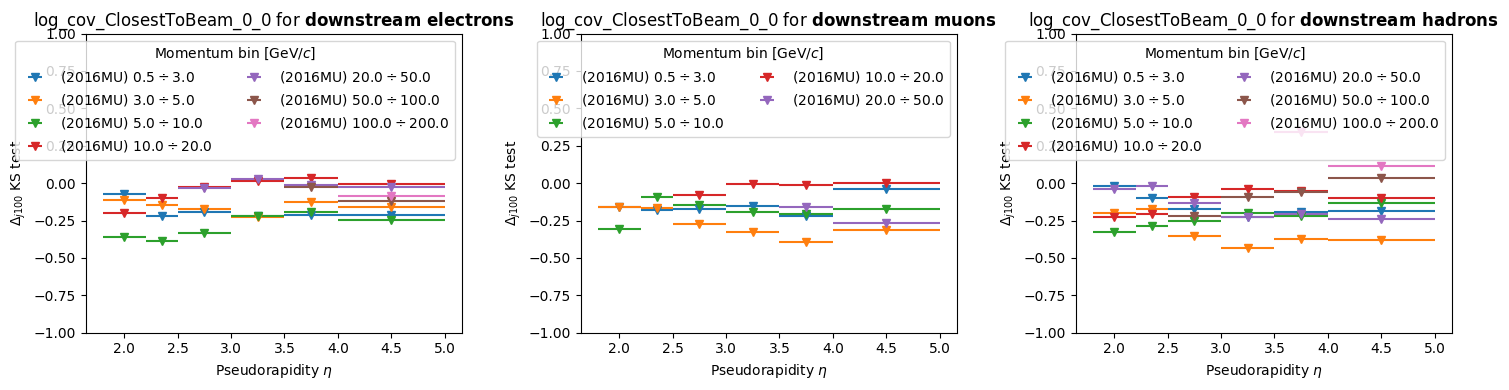

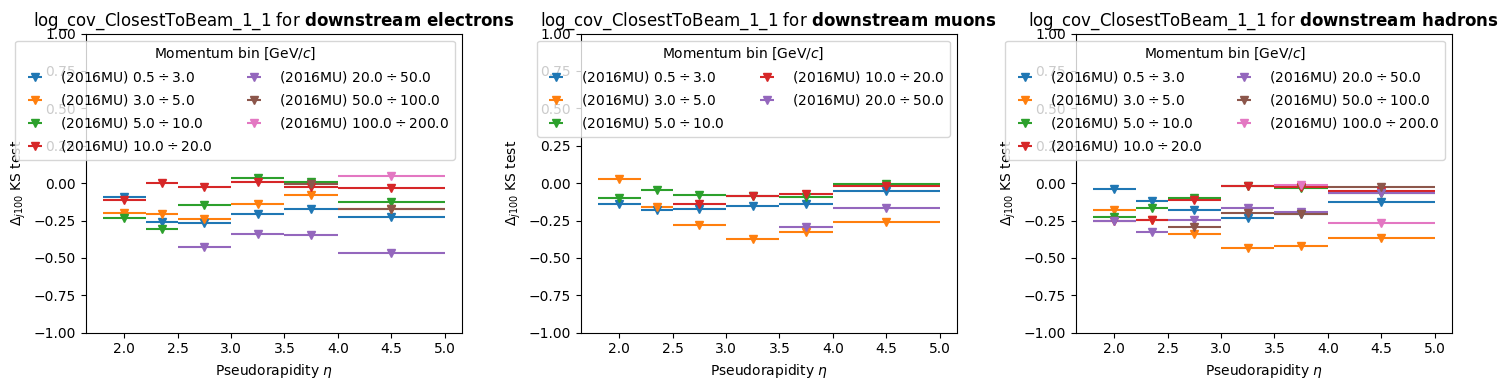

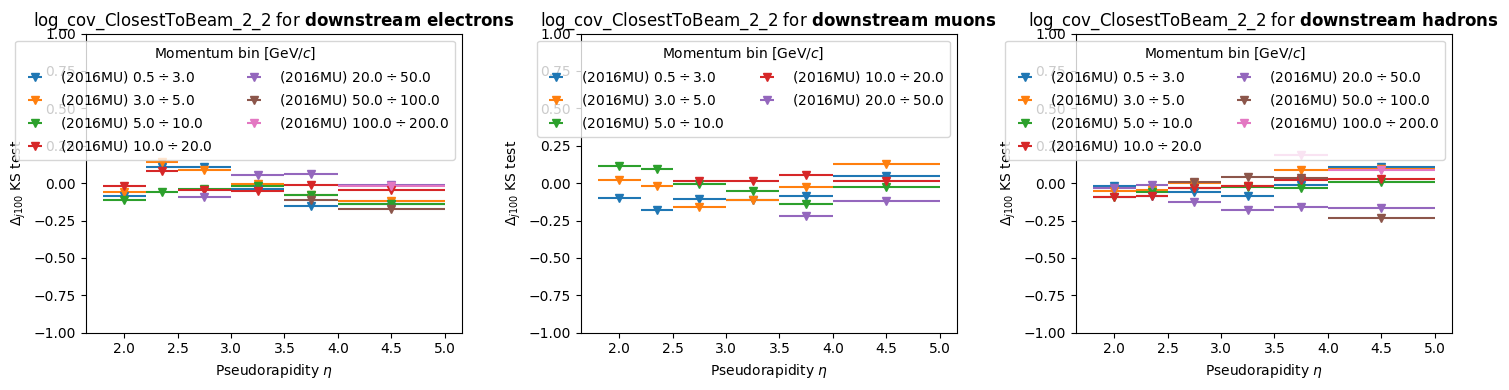

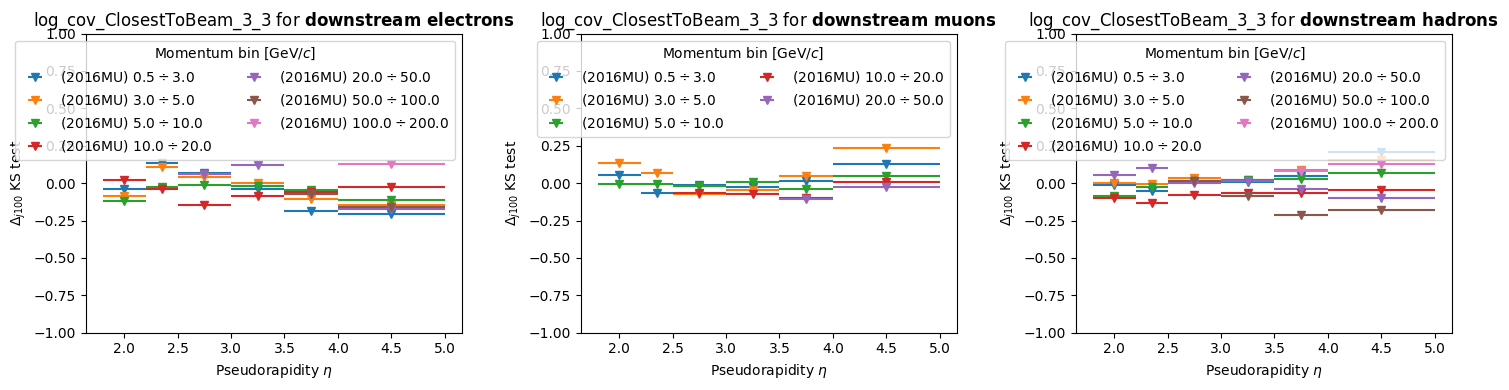

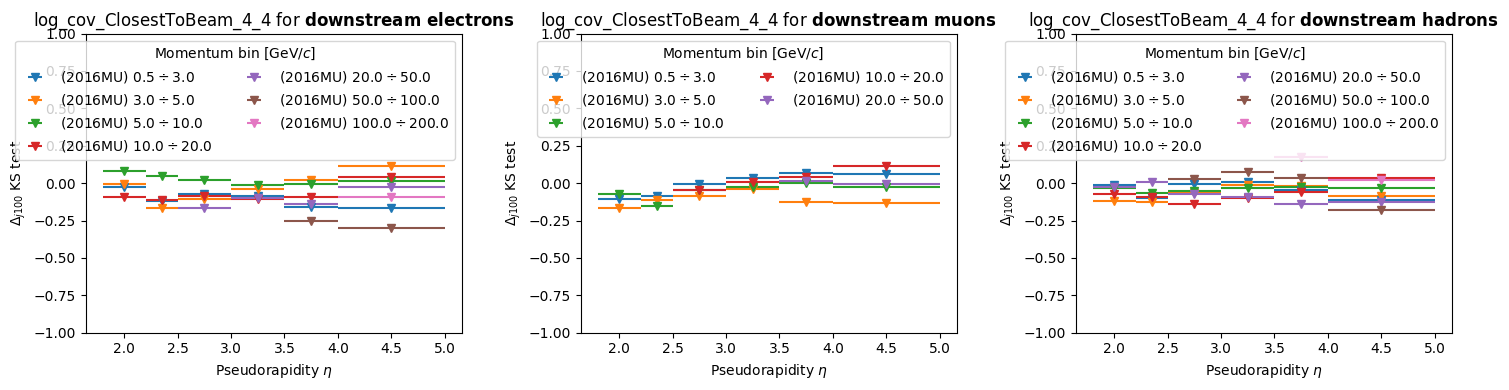

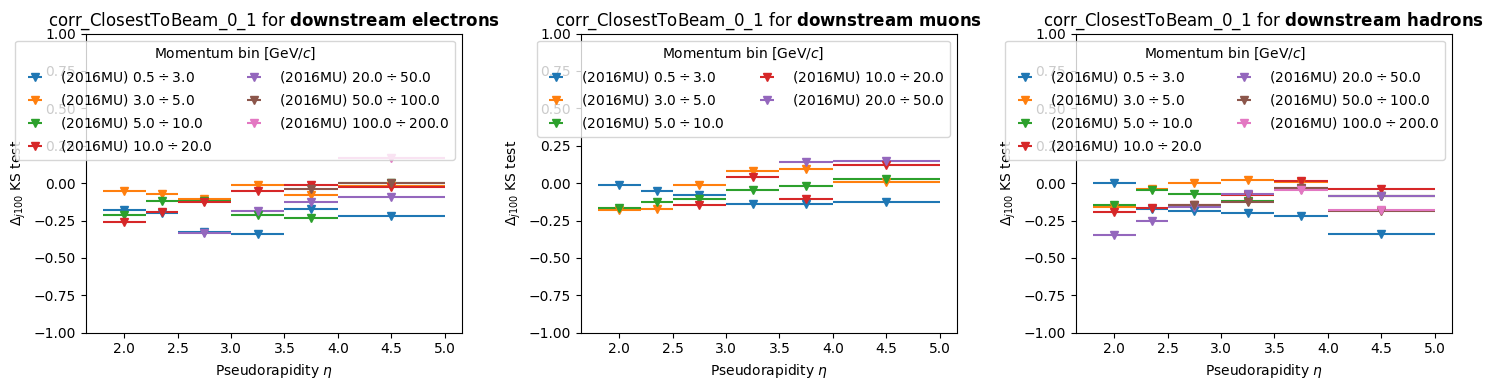

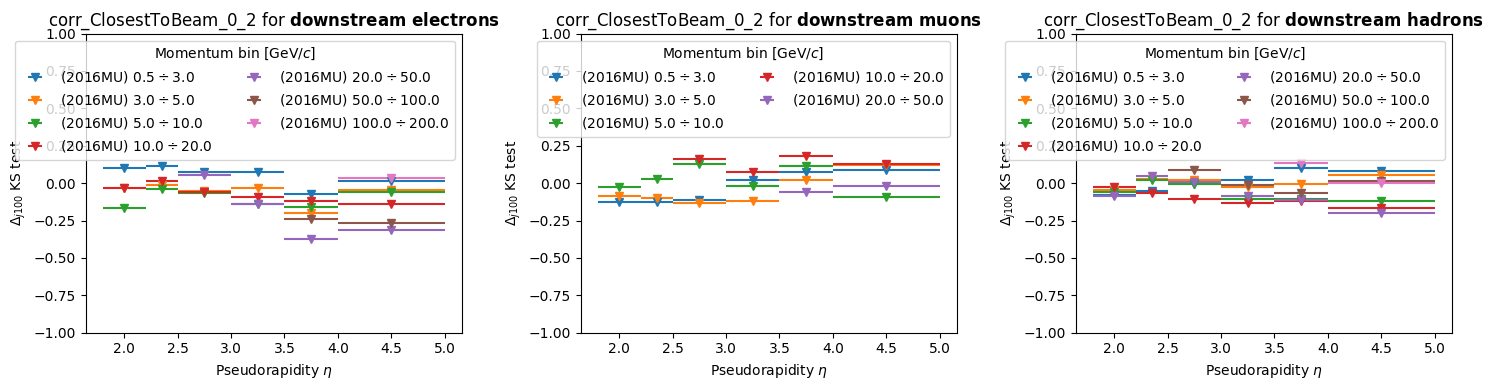

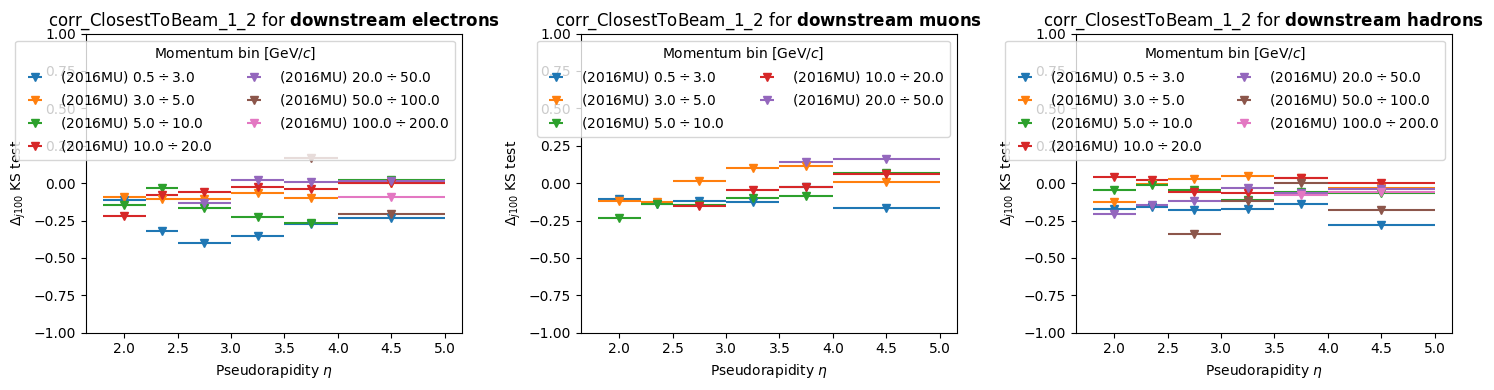

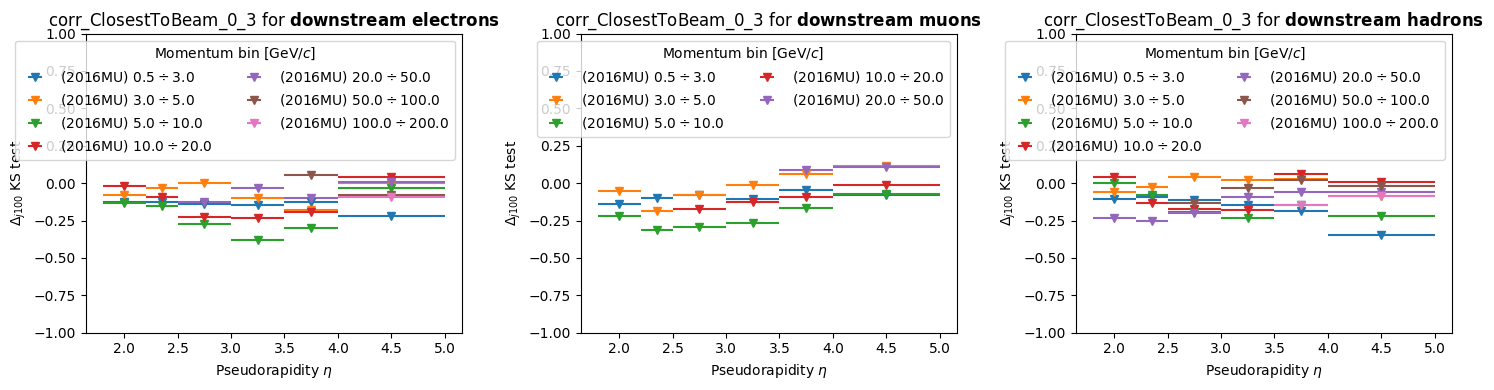

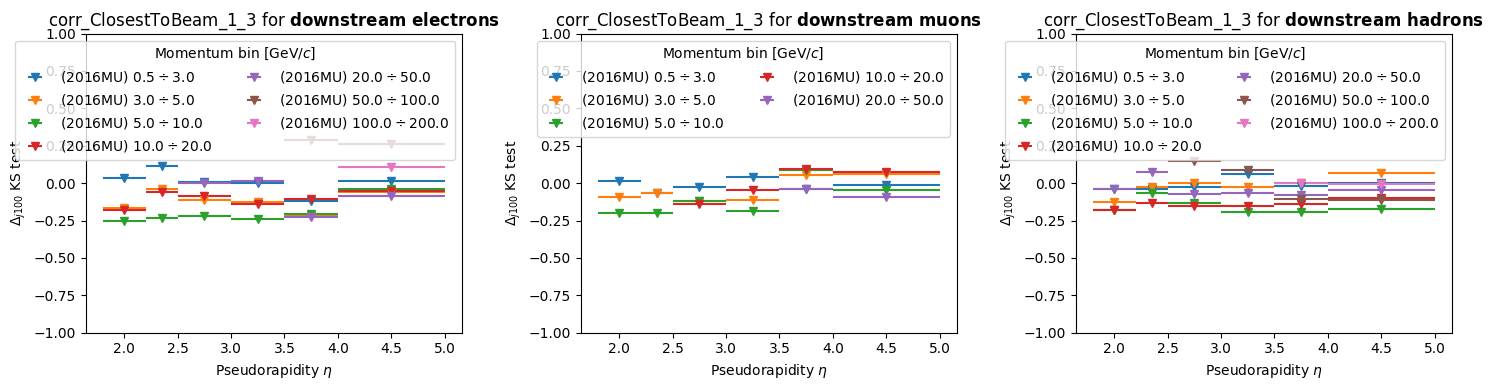

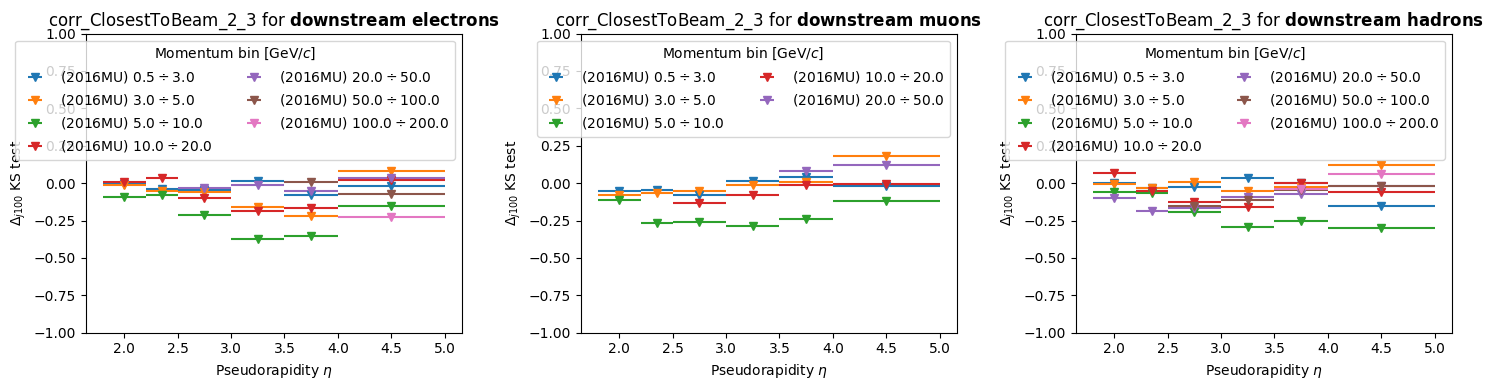

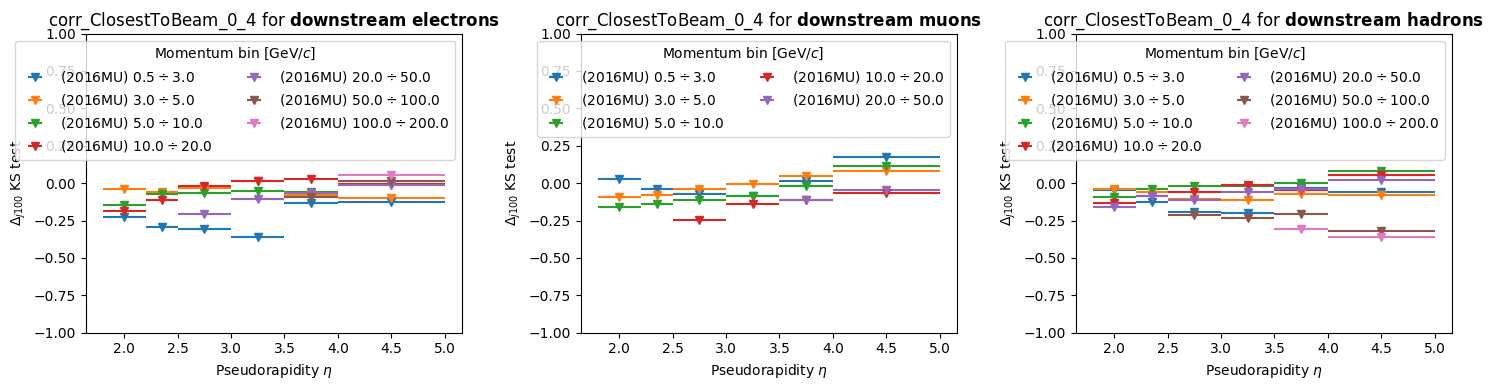

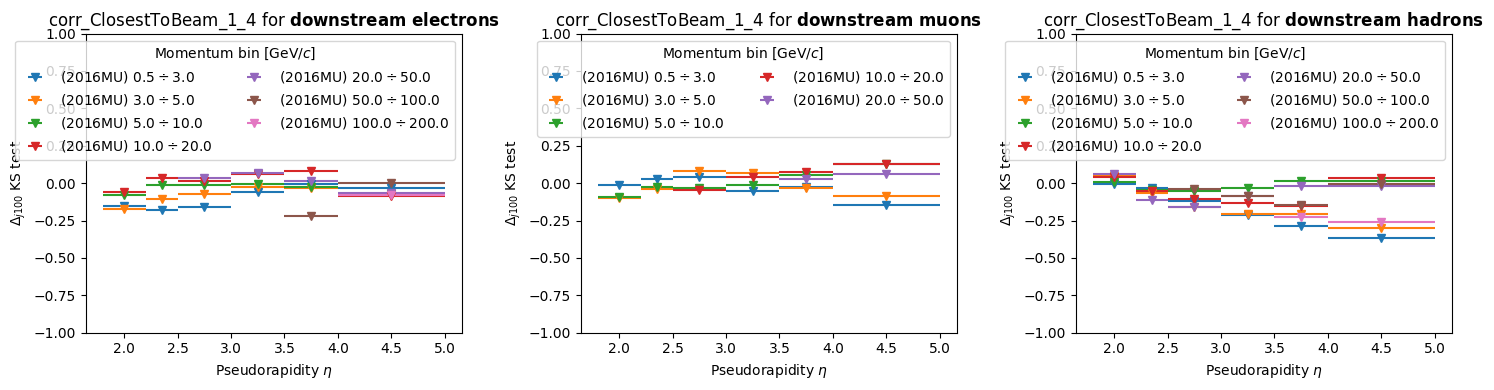

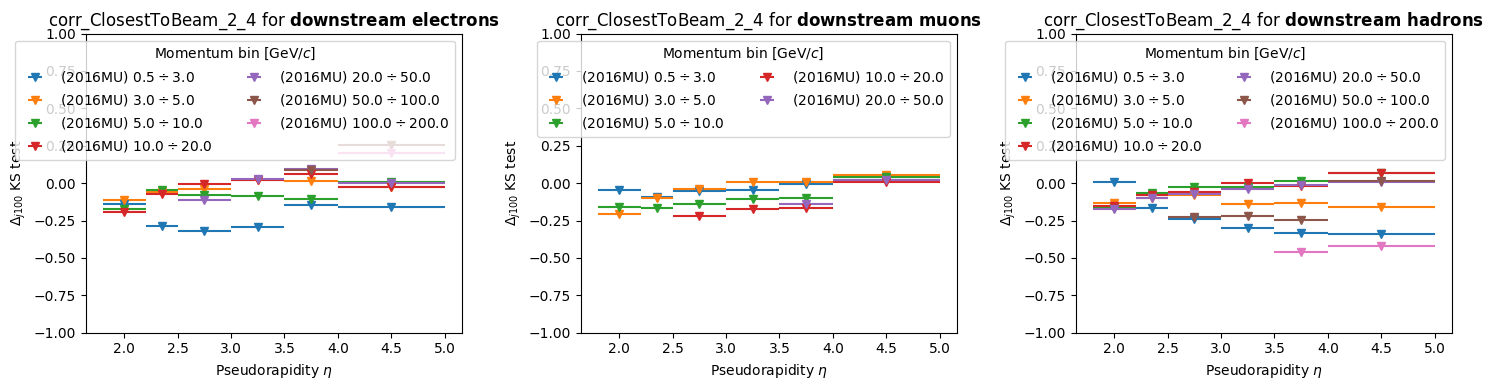

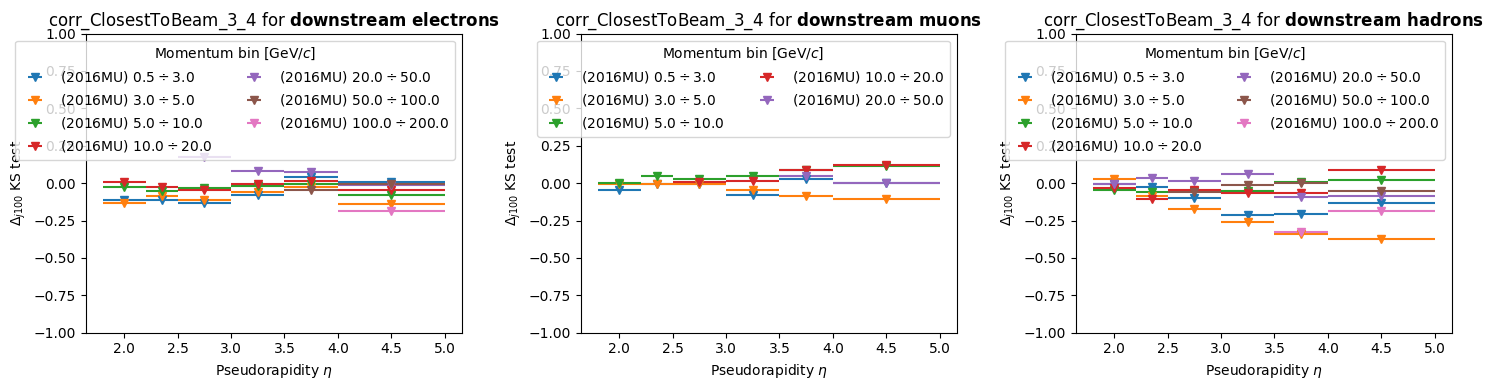

In [21]:
markers = {
    0 : "o",
    1 : "v",
    2 : "^",
    3 : "<",
    4 : ">",
}

for track_type in track_types:
    for label in labels:
        plt.figure(figsize=(15, 4))
        for iPlot, part_type in enumerate(parts, 1):            
            part_name = dict(h="hadron", e="electron", mu="muon")[part_type]
            plt.subplot(1, 3, iPlot)
            
            xAxis,xerr     = dict(),dict()
            y_points,pulls = dict(),dict()
            ##########
            for i,train_key in enumerate(models_collection.keys()):
                bin_ks = reliable_ks_tests[train_key].query(f"track_type=='{track_type}' and part_type=='{part_type}' and variable=='{label}'")
                #display(bin_ks)
                
                xAxis[train_key],xerr[train_key]     = dict(),dict()
                y_points[train_key],pulls[train_key] = dict(),dict()
                for (p_min, p_max), df in bin_ks.groupby(['p_min', 'p_max']):
                    xAxis[train_key][(p_min, p_max)]   = (df.eta_min + df.eta_max)/2
                    y_points[train_key][(p_min,p_max)] = df.ks_stat
                    xerr[train_key][(p_min,p_max)]     = np.c_[xAxis[train_key][(p_min, p_max)]- df.eta_min, df.eta_max - xAxis[train_key][(p_min, p_max)]].T
                    
                    
            ##########
            for (p_min, p_max) in xAxis[target_tset].keys():
                ref_y = y_points[target_tset][(p_min, p_max)]
                for i,train_key in enumerate(models_collection.keys()):
                    if train_key == target_tset: continue
                    else:
                        # values less than zero means better model because KS is smaller
                        pulls[train_key][(p_min, p_max)] = y_points[train_key][(p_min, p_max)] - ref_y
                        plt.errorbar(xAxis[train_key][(p_min, p_max)],pulls[train_key][(p_min, p_max)],xerr=xerr[train_key][(p_min, p_max)],
                                     yerr=None,fmt=markers[i%len(markers)],label=f"({train_key}) ${p_min:.1f} \div {p_max:.1f}$")
                        
            
            #bin_ks = reliable_ks_tests[target_tset].query(f"track_type=='{track_type}' and part_type=='{part_type}' and variable=='{label}'")
            #display(bin_ks)
            
            #for (p_min, p_max), df in bin_ks.groupby(['p_min', 'p_max']):
            #    xAxis = (df.eta_min + df.eta_max)/2
            #    y_points = 
            #    plt.errorbar(xAxis, df.ks_stat, xerr=np.c_[xAxis - df.eta_min, df.eta_max - xAxis].T, yerr=None, 
            #                 fmt='o', label=f"${p_min:.1f} \div {p_max:.1f}$")
            plt.legend(title="Momentum bin [GeV/$c$]", ncol=2)
            plt.xlabel("Pseudorapidity $\eta$")
            plt.ylabel(r"$\Delta_{"+f"{target_tset}"+r"}$ KS test")
            plt.title(f"{label} for $\mathbf{{{track_type}\ {part_name}s}}$")
            plt.ylim(-1,1)
        plt.tight_layout()
        plt.show()

## Conclusion
In this notebook we discussed the validation procedure of the resolution model, comparing the distributions of the predicted features with the reference test set.

Additional splitting and variables might be included in the future to provide a more comprhensive view on the performance of the model.

To ease the identification of regions where the model is weaker, we draw the KS distance obtained comparing the distribution of each variable, in each kinematic bin.

In [23]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    import os,yaml
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nb_save  = nb_save+models_collection[target_tset]['TRAINING_DATA_FOLDER'] # according to train data
    if not os.path.isdir(nb_save): os.makedirs(nb_save)                    # create if not exists
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Covariance-validation-comparison.ipynb"                 # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    print("Exporting models comparison YAML file")
    with open(nb_save+'/'+nb_filename.replace("ipynb","yaml"), 'w') as file:
        yaml.dump(train_conf, file)
        
    for ext in extensions:
        os.system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exporting models comparison YAML file
Exported Covariance-validation-comparison.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports/j100
